In [2]:
import uproot3 as up3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
sys.path.append("../")
from src.data import load_root_file
from src.transforms import rotate_to_microboone, translate_to_microboone

# Background
* Study the background events
* For now : cut 0 tracks 1 shower
* study angles -> can we use $cos(\theta_\text{NuMI})$ again?

In [3]:
CUT_SHOWERS = 1
CUT_TRACKS = 0

vars = ['reco_asso_showers', 'reco_asso_tracks', 'reco_shower_dirx', 'reco_shower_diry', 'reco_shower_dirz', 'reco_shower_energy_max']
bkg_path = "../data/root/background/"

def cuts(df):
    # for now, 0 tracks, 1 shower
    df = df[df['reco_asso_showers'] == CUT_SHOWERS]
    df = df[df['reco_asso_tracks'] == CUT_TRACKS]
    return df


bkg_incryo_df = pd.concat([load_root_file("run1_NuMI_nu_overlay_with_weights.root", bkg_path, vars, cuts, 10_000, 'vertex_tree;269'), 
                          load_root_file("run1_NuMI_nu_overlay_with_weights.root", bkg_path, vars, cuts, 10_000, 'vertex_tree;268')])
bkg_dirt_df = pd.concat([load_root_file("run1_NuMI_dirt_with_weights.root", bkg_path, vars, cuts, 10_000, 'vertex_tree;127'),
                        load_root_file("run1_NuMI_dirt_with_weights.root", bkg_path, vars, cuts, 10_000, 'vertex_tree;126')])
bkg_beamoff_df = load_root_file("run1_NuMI_offbeam_full_set_sp.root", bkg_path, vars, cuts, 10_000, "singlephotonana")

bkg_total = pd.concat([bkg_incryo_df, bkg_dirt_df, bkg_beamoff_df])
display(bkg_total.head())

/home/alex/projects/DarkElectronScatter/notebooks/../src/data.py:53: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat((df, df_temp))
/home/alex/projects/DarkElectronScatter/notebooks/../src/data.py:53: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat((df, df_temp))
/home/alex/projects/DarkElectronScatter/notebooks/../src/data.py:53: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer e

,reco_asso_showers,reco_asso_tracks,reco_shower_dirx,reco_shower_diry,reco_shower_dirz,reco_shower_energy_max,cos_theta_numi
133,1,0,-0.974157,0.217500,0.060930,29.204729,-0.385853
384,1,0,-0.190203,0.542646,0.818143,122.407497,0.662900
395,1,0,-0.204667,-0.967507,0.148464,241.333995,-0.010458
514,1,0,0.341527,-0.595694,0.726985,25.527555,0.772439
574,1,0,-0.196637,-0.769160,0.608052,40.072928,0.409836


In [4]:
print(len(bkg_incryo_df), len(bkg_dirt_df), len(bkg_beamoff_df))
# 15995 4897 4731

print(bkg_incryo_df.iloc[0]['reco_shower_dirx']**2+bkg_incryo_df.iloc[0]['reco_shower_diry']**2+bkg_incryo_df.iloc[0]['reco_shower_dirz']**2)

15995 4897 4731
0.9999998564896306


In [5]:
# translation and rotation from beamline coordinate system
# to detector coordinate system


rotate_to_microboone(np.array([1, 0, 0]))

array([0.92103854, 0.0227135 , 0.38880858])

In [6]:
# get the signal data
sig_path = "../data/root/BdNMC/"
# for now, concat all scalar and concat all sig?
dm_types = ["scalar", "fermion"]

sig_scalar_df = pd.DataFrame()
sig_fermion_df = pd.DataFrame()

for dm in dm_types:
    for file in os.listdir(sig_path + dm):
        if file.endswith(".root"):
            # get the approx shower dir with the electron momentum
            try:
                df = up3.open(sig_path + dm + "/" + file)["elecron_tree"].pandas.df()
            except:
                print("Error with file:", file)
                continue
            px, py, pz = df["electron_px"], df["electron_py"], df["electron_pz"]

            px, py, pz = rotate_to_microboone(np.array([px, py, pz]))
            # get the direction vector
            v = np.array([px, py, pz])
            # normalize
            v = v / np.linalg.norm(v, axis=0)
            #print(v[0]**2 + v[1]**2 + v[2]**2)

            v_numi=np.array([0.462372, 0.0488541, 0.885339])
            v_shwr = np.array([v[0], v[1], v[2]])
            df["cos_theta_numi"] = np.dot(v_shwr.T, v_numi)

            meson, _, _, ma, _, dt = file.split("_")
            dt = dt.split(".")[0]

            if dm == "scalar":
                df["meson"] = meson
                df["ma"] = ma
                df["dt"] = dt
                sig_scalar_df = pd.concat([sig_scalar_df, df])
            
            elif dm == "fermion":
                df["meson"] = meson
                df["ma"] = ma
                df["dt"] = dt
                sig_fermion_df = pd.concat([sig_fermion_df, df])
            
            else:
                print("???")

display(sig_scalar_df.head())
display(sig_fermion_df.head())

Error with file: eta_fermion_ma_0.06_dt_0.33.root
Error with file: eta_fermion_ma_0.03_dt_0.33.root
Error with file: eta_fermion_ma_0.05_dt_0.33.root
Error with file: eta_fermion_ma_0.01_dt_0.33.root
Error with file: pi0_fermion_ma_0.01_dt_0.33.root
Error with file: eta_fermion_ma_0.07_dt_0.33.root
Error with file: pi0_fermion_ma_0.04_dt_0.33.root
Error with file: eta_fermion_ma_0.09_dt_0.33.root
Error with file: pi0_fermion_ma_0.02_dt_0.33.root
Error with file: eta_fermion_ma_0.08_dt_0.33.root
Error with file: pi0_fermion_ma_0.03_dt_0.33.root
Error with file: eta_fermion_ma_0.01_dt_0.6.root
Error with file: eta_fermion_ma_0.1_dt_0.33.root
Error with file: eta_fermion_ma_0.04_dt_0.33.root
Error with file: eta_fermion_ma_0.02_dt_0.33.root
Error with file: pi0_fermion_ma_0.05_dt_0.33.root


,electron_id,electron_energy,electron_px,electron_py,electron_pz,electron_origin_x,electron_origin_y,electron_origin_z,electron_origin_t0,electron_vx,cos_theta_numi,meson,ma,dt
entry,,,,,,,,,,,,,,
0,215904,0.029395,0.007538,0.003340,0.028210,20.282111,26.022074,244.309073,8.358984e-07,0.0,0.808496,pi0,0.01,0
1,380328,0.322386,0.037986,0.041224,0.317475,56.258945,79.211222,732.246410,2.477325e-06,0.0,0.717382,pi0,0.01,0
2,907114,0.054051,0.006390,0.012818,0.052116,132.323938,179.232142,1649.803959,5.567428e-06,0.0,0.704311,pi0,0.01,0
3,1296882,0.030038,0.004085,0.000382,0.029752,7.976336,9.582309,295.425830,1.003158e-06,0.0,0.735477,pi0,0.01,0
4,1630486,0.037081,0.001478,-0.001247,0.037027,60.106142,83.680653,766.586790,2.596602e-06,0.0,0.666560,pi0,0.01,0


,electron_id,electron_energy,electron_px,electron_py,electron_pz,electron_origin_x,electron_origin_y,electron_origin_z,electron_origin_t0,electron_vx,cos_theta_numi,meson,ma,dt
entry,,,,,,,,,,,,,,
0,1671901,0.055747,-0.001027,0.000845,0.055728,138.427197,190.534769,1758.578317,5.931673e-06,0.0,0.622146,pi0,0.01,0
1,1673936,0.001706,-0.000985,-0.000045,0.001295,16.446706,21.359485,216.812615,7.429296e-07,0.0,0.039766,pi0,0.01,0
2,126131,0.045298,0.007872,0.000055,0.044606,27.513085,37.427672,345.043364,1.174736e-06,0.0,0.760924,pi0,0.01,0
3,445377,0.109203,0.017342,0.012985,0.107031,26.361674,36.289614,344.393206,1.171974e-06,0.0,0.746055,pi0,0.01,0
4,713327,0.021827,0.006005,0.005541,0.020233,7.966455,11.287375,300.097683,1.018904e-06,0.0,0.801765,pi0,0.01,0


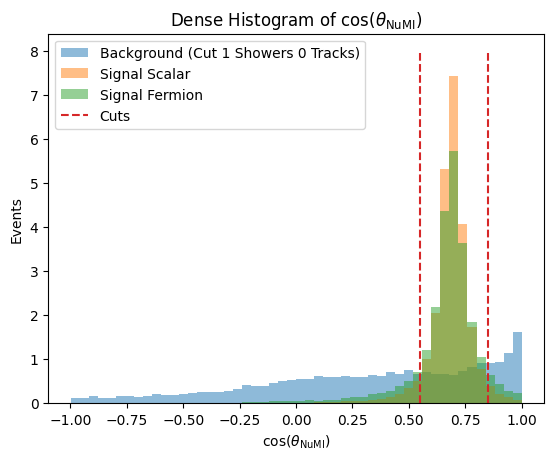

In [7]:
# Now get the directional distributions of these events.
# lets use cos(theta_numi), as that worked well last time
# should check cos(theta_numi) for the signal events too

fig = plt.figure()
ax = fig.add_subplot(111)
_, bins, _ =ax.hist(bkg_total['cos_theta_numi'], bins=50, alpha=0.5, label='Background (Cut 1 Showers 0 Tracks)', density=True)
ax.hist(sig_scalar_df['cos_theta_numi'], bins=bins, alpha=0.5, label='Signal Scalar', density=True)
ax.hist(sig_fermion_df['cos_theta_numi'], bins=bins, alpha=0.5, label='Signal Fermion', density=True)
ax.vlines([0.55, 0.85], 0, 8, label="Cuts", color='tab:red', linestyles='dashed')

ax.set(xlabel=r"$\cos(\theta_{\text{NuMI}})$", ylabel="Events", title=r"Dense Histogram of $\cos(\theta_{\text{NuMI}})$")
ax.legend()
fig.savefig("../plots/cos_theta_numi_all.png")
fig.savefig("../plots/cos_theta_numi_all.pdf")
plt.show()

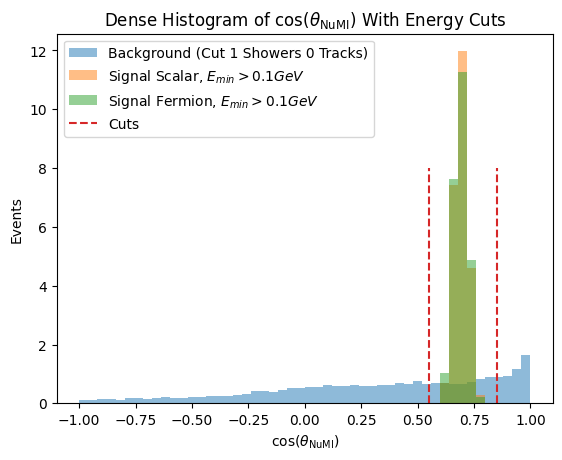

In [8]:
# cut on energy
E_min = 0.1 # GeV

fig = plt.figure()
ax = fig.add_subplot(111)
_, bins, _ =ax.hist(bkg_total['cos_theta_numi'], bins=50, alpha=0.5, label='Background (Cut 1 Showers 0 Tracks)', density=True)
sig_scalar_df_cut = sig_scalar_df[sig_scalar_df["electron_energy"]>0.1]
sig_fermion_df_cut = sig_fermion_df[sig_fermion_df["electron_energy"]>0.1]
ax.hist(sig_scalar_df_cut['cos_theta_numi'], bins=bins, alpha=0.5, label='Signal Scalar, $E_{min}>0.1 GeV$', density=True)
ax.hist(sig_fermion_df_cut['cos_theta_numi'], bins=bins, alpha=0.5, label='Signal Fermion, $E_{min}>0.1 GeV$', density=True)
ax.vlines([0.55, 0.85], 0, 8, label="Cuts", color='tab:red', linestyles='dashed')

ax.set(xlabel=r"$\cos(\theta_{\text{NuMI}})$", ylabel="Events", title=r"Dense Histogram of $\cos(\theta_{\text{NuMI}})$ With Energy Cuts")
ax.legend()
fig.savefig("../plots/cos_theta_numi_all_cut.png")
fig.savefig("../plots/cos_theta_numi_all_cut.pdf")
plt.show()

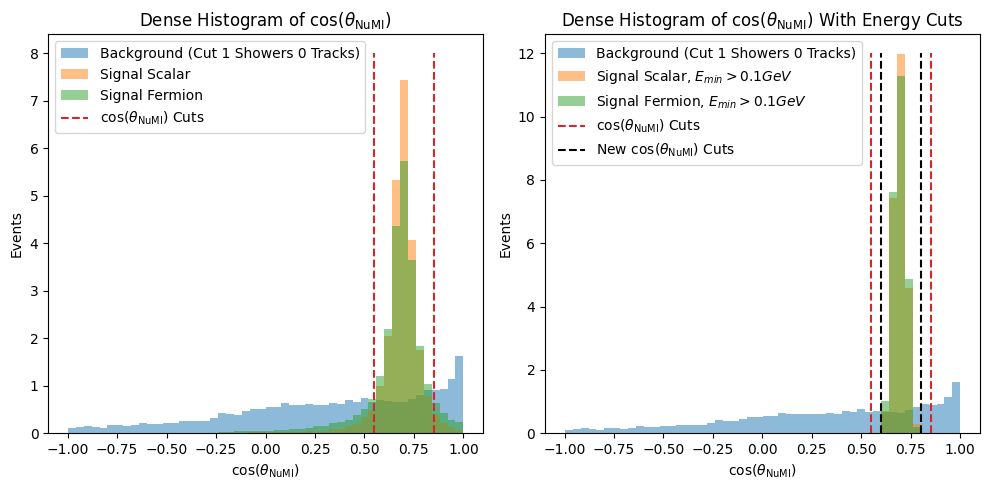

In [9]:
fig = plt.figure(figsize=(10,5))
ax = fig.subplots(1,2)
_, bins, _ =ax[0].hist(bkg_total['cos_theta_numi'], bins=50, alpha=0.5, label='Background (Cut 1 Showers 0 Tracks)', density=True)
_, bins, _ =ax[1].hist(bkg_total['cos_theta_numi'], bins=50, alpha=0.5, label='Background (Cut 1 Showers 0 Tracks)', density=True)
ax[0].hist(sig_scalar_df['cos_theta_numi'], bins=bins, alpha=0.5, label='Signal Scalar', density=True)
ax[0].hist(sig_fermion_df['cos_theta_numi'], bins=bins, alpha=0.5, label='Signal Fermion', density=True)
ax[0].vlines([0.55, 0.85], 0, 8, label=r"$\cos(\theta_\text{NuMI})$ Cuts", color='tab:red', linestyles='dashed')

ax[1].hist(sig_scalar_df_cut['cos_theta_numi'], bins=bins, alpha=0.5, label='Signal Scalar, $E_{min}>0.1 GeV$', density=True)
ax[1].hist(sig_fermion_df_cut['cos_theta_numi'], bins=bins, alpha=0.5, label='Signal Fermion, $E_{min}>0.1 GeV$', density=True)
ax[1].vlines([0.55, 0.85], 0, 12, label=r"$\cos(\theta_\text{NuMI})$ Cuts", color='tab:red', linestyles='dashed')
ax[1].vlines([0.6, 0.8], 0, 12, label=r"New $\cos(\theta_\text{NuMI})$ Cuts", color='k', linestyles='dashed')

ax[1].set(xlabel=r"$\cos(\theta_{\text{NuMI}})$", ylabel="Events", title=r"Dense Histogram of $\cos(\theta_{\text{NuMI}})$ With Energy Cuts")
ax[0].set(xlabel=r"$\cos(\theta_{\text{NuMI}})$", ylabel="Events", title=r"Dense Histogram of $\cos(\theta_{\text{NuMI}})$")
ax[0].legend()
ax[1].legend()
fig.tight_layout()
fig.savefig("../plots/cos_theta_numi_merged.pdf")
fig.savefig("../plots/cos_theta_numi_merged.png")
plt.show()


In [10]:
# get the signal data
sig_path = "../data/root/BdNMC/"
# for now, concat all scalar and concat all sig?
dm_types = ["scalar", "fermion"]

sig_scalar_df = pd.DataFrame()
sig_fermion_df = pd.DataFrame()

for dm in dm_types:
    for file in os.listdir(sig_path + dm):
        if file.endswith(".root"):
            # get the approx shower dir with the electron momentum
            try:
                df = up3.open(sig_path + dm + "/" + file)["elecron_tree"].pandas.df()
            except:
                print("Error with file:", file)
                continue

            for event in df.iterrows():
                px, py, pz = event[1]["electron_px"], event[1]["electron_py"], event[1]["electron_pz"]

                px, py, pz = rotate_to_microboone(np.array([px, py, pz]))
                #print(px, py, pz)
                # get the direction vector
                v = np.array([px, py, pz])
                # normalize
                v = v / np.linalg.norm(v)
                #print(v[0]**2 + v[1]**2 + v[2]**2)

                v_numi=np.array([0.462372, 0.0488541, 0.885339])
                v_shwr = np.array([v[0], v[1], v[2]])
                cos_theta_numi = np.dot(v_shwr.T, v_numi)

                meson, _, _, ma, _, dt = file.split("_")
                dt = dt.split(".")[0]
                df.at[event[0], "cos_theta_numi"] = cos_theta_numi
                df.at[event[0],"meson"] = meson
                df.at[event[0],"ma"] = ma
                df.at[event[0],"dt"] = dt


            if dm == "scalar":

                sig_scalar_df = pd.concat([sig_scalar_df, df])
            
            elif dm == "fermion":
                df["meson"] = meson
                df["ma"] = ma
                df["dt"] = dt
                sig_fermion_df = pd.concat([sig_fermion_df, df])
            
            else:
                    print("???")

display(sig_scalar_df.head())
display(sig_fermion_df.head())

Error with file: eta_fermion_ma_0.06_dt_0.33.root
Error with file: eta_fermion_ma_0.03_dt_0.33.root
Error with file: eta_fermion_ma_0.05_dt_0.33.root
Error with file: eta_fermion_ma_0.01_dt_0.33.root
Error with file: pi0_fermion_ma_0.01_dt_0.33.root
Error with file: eta_fermion_ma_0.07_dt_0.33.root
Error with file: pi0_fermion_ma_0.04_dt_0.33.root
Error with file: eta_fermion_ma_0.09_dt_0.33.root
Error with file: pi0_fermion_ma_0.02_dt_0.33.root
Error with file: eta_fermion_ma_0.08_dt_0.33.root
Error with file: pi0_fermion_ma_0.03_dt_0.33.root
Error with file: eta_fermion_ma_0.01_dt_0.6.root
Error with file: eta_fermion_ma_0.1_dt_0.33.root
Error with file: eta_fermion_ma_0.04_dt_0.33.root
Error with file: eta_fermion_ma_0.02_dt_0.33.root
Error with file: pi0_fermion_ma_0.05_dt_0.33.root


,electron_id,electron_energy,electron_px,electron_py,electron_pz,electron_origin_x,electron_origin_y,electron_origin_z,electron_origin_t0,electron_vx,cos_theta_numi,meson,ma,dt
entry,,,,,,,,,,,,,,
0,215904,0.029395,0.007538,0.003340,0.028210,20.282111,26.022074,244.309073,8.358984e-07,0.0,0.808496,pi0,0.01,0
1,380328,0.322386,0.037986,0.041224,0.317475,56.258945,79.211222,732.246410,2.477325e-06,0.0,0.717382,pi0,0.01,0
2,907114,0.054051,0.006390,0.012818,0.052116,132.323938,179.232142,1649.803959,5.567428e-06,0.0,0.704311,pi0,0.01,0
3,1296882,0.030038,0.004085,0.000382,0.029752,7.976336,9.582309,295.425830,1.003158e-06,0.0,0.735477,pi0,0.01,0
4,1630486,0.037081,0.001478,-0.001247,0.037027,60.106142,83.680653,766.586790,2.596602e-06,0.0,0.666560,pi0,0.01,0


,electron_id,electron_energy,electron_px,electron_py,electron_pz,electron_origin_x,electron_origin_y,electron_origin_z,electron_origin_t0,electron_vx,cos_theta_numi,meson,ma,dt
entry,,,,,,,,,,,,,,
0,1671901,0.055747,-0.001027,0.000845,0.055728,138.427197,190.534769,1758.578317,5.931673e-06,0.0,0.622146,pi0,0.01,0
1,1673936,0.001706,-0.000985,-0.000045,0.001295,16.446706,21.359485,216.812615,7.429296e-07,0.0,0.039766,pi0,0.01,0
2,126131,0.045298,0.007872,0.000055,0.044606,27.513085,37.427672,345.043364,1.174736e-06,0.0,0.760924,pi0,0.01,0
3,445377,0.109203,0.017342,0.012985,0.107031,26.361674,36.289614,344.393206,1.171974e-06,0.0,0.746055,pi0,0.01,0
4,713327,0.021827,0.006005,0.005541,0.020233,7.966455,11.287375,300.097683,1.018904e-06,0.0,0.801765,pi0,0.01,0


# Plot Energies

33041.243860749055


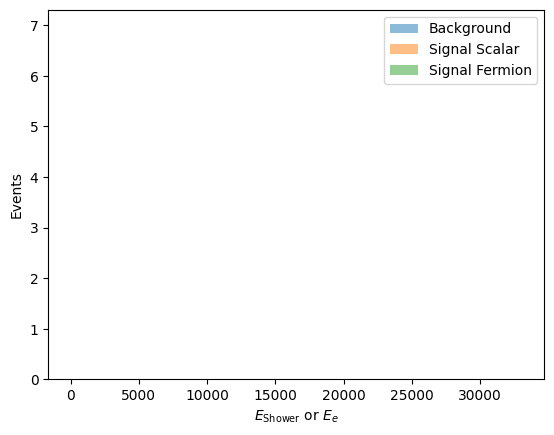

In [11]:
fig = plt.figure()
ax = fig.add_subplot(111)
print(np.max(bkg_total['reco_shower_energy_max']))
mins = np.min([np.min(bkg_total['reco_shower_energy_max']), np.min(sig_scalar_df['electron_energy']), np.min(sig_fermion_df['electron_energy'])])
maxs = np.max([np.max(bkg_total['reco_shower_energy_max']), np.max(sig_scalar_df['electron_energy']), np.max(sig_fermion_df['electron_energy'])])
bins = np.linspace(mins, maxs, 51)
ax.hist(bkg_total['reco_shower_energy_max'], bins=bins, alpha=0.5, label='Background', density=True)
ax.hist(sig_scalar_df['electron_energy'], bins=50, alpha=0.5, label='Signal Scalar', density=True)
ax.hist(sig_fermion_df['electron_energy'], bins=50, alpha=0.5, label='Signal Fermion', density=True)

ax.set(xlabel=r"$E_\text{Shower}$ or $E_e$", ylabel="Events")
ax.legend()
plt.show()